In [1]:
import os
import json
import spacy
import datasets


ROOT_DIR = "../.."
ORIGINAL_MOCHA_DIR = f"{ROOT_DIR}/data/metric-modeling/mocha"
SPLITS = ("train", "dev", "test")
DATASETS = ('cosmosqa', 'drop', 'mcscript', 'narrativeqa', 'quoref', 'socialiqa')

PREPROC_DIR = f"{ROOT_DIR}/data/raw_splits"
os.makedirs(PREPROC_DIR, exist_ok=True)

In [2]:
filepath = f"{ORIGINAL_MOCHA_DIR}/{SPLITS[0]}.json"

data = json.load(open(filepath))
datasets = list(data.keys())

In [54]:
def read_json_dataset(parent_dir, filename, dataset=None) -> dict:
    """Loads the dataset from the specified path. 
    
    It assumes the dataset is in JSON format and that is
    represented as {tag1: {examples}, tag2: {...}, ...}
    where tag1 and tag2 are dataset tags that the user
    can specify. If none are specified all the datasets
    will be returned.
    """
    data = json.load(open(f"{parent_dir}/{filename}.json"))
    
    if dataset is None:
        datasets = list(data.keys())
    else:
        datasets = dataset if isinstance(dataset, list) else [dataset]
    
    data = {d: datum for d, datum in data.items() if d in datasets}
    return data


# Sanity check (:
data = read_json_dataset(ORIGINAL_MOCHA_DIR, "dev", "narrativeqa")

In [65]:
from bert_score import score as BERT_SCORE
from datasets import load_metric
from pycocoevalcap.meteor.meteor import Meteor as pccMeteor
from pycocoevalcap.rouge.rouge import Rouge as pccRouge
from pycocoevalcap.bleu.bleu import Bleu as pccBleu


def remove_punc(s):
    return s.replace('?', '').replace('.', '').replace('!', '')

def update_examples(examples: dict, key, values):
    assert len(examples) == len(values)

    for example, value in zip(examples, values):
        example[key] = value


def add_bleu(mocha_dataset, order: int=4):
    BLEU = pccBleu(order)

    for dataset, examples in mocha_dataset.items():
        refs = {i: [remove_punc(instance['reference'])] for i, instance in
                enumerate(examples.values())}
        cands = {i: [remove_punc(instance['candidate'])] for i, instance in
                 enumerate(examples.values())}
        
        # compute_scores return (aggregate-bleu, instance-wise bleu)
        # -- by accessing the first index, we get the bleu per instance
        bleu_scores = BLEU.compute_score(refs, cands, verbose=0)[1]
        
        for i in range(order):
            update_examples(examples.values(), f"bleu{i+1}", bleu_scores[i])


def add_meteor(mocha_dataset):
    METEOR = pccMeteor()

    for dataset, examples in mocha_dataset.items():
        refs = {i: [remove_punc(instance['reference'])] for i, instance in
                enumerate(examples.values())}
        cands = {i: [remove_punc(instance['candidate'])] for i, instance in
                 enumerate(examples.values())}
        pred_scores = METEOR.compute_score(refs, cands)[1]
        update_examples(examples.values(), "meteor", pred_scores)


def add_rouge(mocha_dataset):
    ROUGE = pccRouge()

    for dataset, examples in mocha_dataset.items():
        refs = {i: [remove_punc(instance['reference'])] for i, instance in
                enumerate(examples.values())}
        cands = {i: [remove_punc(instance['candidate'])] for i, instance in
                 enumerate(examples.values())}
        pred_scores = ROUGE.compute_score(refs, cands)[1]
        update_examples(examples.values(), "rougeL", pred_scores)

        
def add_bertscore(mocha_dataset):
    for dataset, examples in mocha_dataset.items():
        refs = [remove_punc(instance['reference']) for instance in examples.values()]
        cands = [remove_punc(instance['candidate']) for instance in examples.values()]
        pred_scores = BERT_SCORE(cands, refs, lang='en')[-1].tolist()
        update_examples(examples.values(), "bertscore", pred_scores)


def add_bleurt(mocha_dataset):
    BLEURT = load_metric("bleurt", keep_in_memory=True)

    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            scores = BLEURT.compute(predictions=[remove_punc(example["candidate"])],
                                    references=[remove_punc(example["reference"])])
            example["bleurt"] = scores["scores"][0]



def add_char_edit_rate(mocha_dataset):
    """Compute word edit rate. 
    
    The formula is like the character_edit_rate but using words
    rather than characters.
    """
    # https://github.com/huggingface/datasets/tree/fad939b5e17b672a4eda7de2cd8e24d98f3d5b26/metrics/wer
    # !pip install jiwer
    CER = load_metric("cer", keep_in_memory=True)
    
    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"])
            reference = remove_punc(example["reference"])

            scores = CER.compute(predictions=[candidate], references=[reference])
            example["char_edit_score"] = scores


def add_word_edit_rate(mocha_dataset):
    """Compute word edit rate. 
    
    The formula is like the character_edit_rate but using words
    rather than characters.
    """
    # https://github.com/huggingface/datasets/tree/fad939b5e17b672a4eda7de2cd8e24d98f3d5b26/metrics/wer
    # !pip install jiwer
    WER = load_metric("wer", keep_in_memory=True)
    
    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"])
            reference = remove_punc(example["reference"])

            scores = WER.compute(predictions=[candidate], references=[reference])
            example["word_edit_score"] = scores
    
def add_recall(mocha_dataset):
    from collections import Counter

    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"]).split()
            reference = remove_punc(example["reference"]).split()

            true_tks, pred_tks = Counter(reference), Counter(candidate)
        
            tp = sum((true_tks & pred_tks).values())
            
            if tp == 0:
                example["recall"] = 0
            else:
                example["recall"] = tp / len(reference)

            example["tp"] = tp
            example["fn"] = len(reference) - tp


def add_precision(mocha_dataset):
    from collections import Counter

    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            candidate = remove_punc(example["candidate"]).split()
            reference = remove_punc(example["reference"]).split()

            true_tks, pred_tks = Counter(reference), Counter(candidate)
        
            tp = sum((true_tks & pred_tks).values())
            example["precision"] = 0 if tp == 0 else tp / len(candidate)

            example["tp"] = tp
            example["fp"] = len(candidate) - tp


def add_f_score(mocha_dataset, beta=1):
    f_name = f"f{beta}_score"
    for dataset, examples in mocha_dataset.items():
        for example in examples.values():
            recall = example["recall"]
            precis = example["precision"]
            
            if precis == 0 or recall == 0:
                example[f_name] = 0
            else:
                beta = beta*beta
                num = precis * recall
                den = (beta * precis + recall)
                example[f_name] = (1+beta) * num / den


def add_rouge_order_n(mocha_dataset, rouge_types, use_stemmer=False):
    ROUGE = load_metric("rouge", keep_in_memory=True) 
    #^Note: requires installing rouge-score (!pip install rouge-score)
    # https://github.com/huggingface/datasets/issues/617

    for dataset, examples in mocha_dataset.items():
        candidate = [[remove_punc(ex["candidate"])] for ex in examples.values()]
        reference = [[remove_punc(ex["reference"])] for ex in examples.values()]

        scores = ROUGE.compute(predictions=candidate,
                               references=reference,
                               use_stemmer=use_stemmer,
                               use_aggregator=False)

        for rouge_type in rouge_types:
            rouge_scores = [s.fmeasure for s in scores[rouge_type]]
            update_examples(examples.values(), "hf_" + rouge_type, rouge_scores)


def add_first_error_position(mocha_dataset):    
    for dataset, examples in mocha_dataset.items():
        raise NotImplementedError
            
def add_word_movers_distance(mocha_dataset):
    # https://markroxor.github.io/gensim/static/notebooks/WMD_tutorial.html
    raise NotImplementedError

def add_sari(mocha_dataset):
    """https://github.com/huggingface/datasets/tree/master/metrics/sari"""
    for dataset, examples in mocha_dataset.items():
        raise NotImplementedError

In [66]:
# add_char_edit_rate(data)
# add_word_edit_rate(data)

add_recall(data)
add_precision(data)
add_f_score(data)

# add_bleu(data)
add_rouge(data)
add_rouge_order_n(data, ["rouge1", "rouge2", "rougeL", "rougeLsum"])
# add_meteor(data)

# add_bertscore(data)
#add_bleurt(data)

TypeError: 'str' object does not support item assignment

In [59]:
rouge_coco = []
rouge_hf = []
for example in data["narrativeqa"].values(): 
    rouge_coco.append(example["rougeL"])
    rouge_hf.append(example["_rougeL"])

<AxesSubplot:ylabel='Probability'>

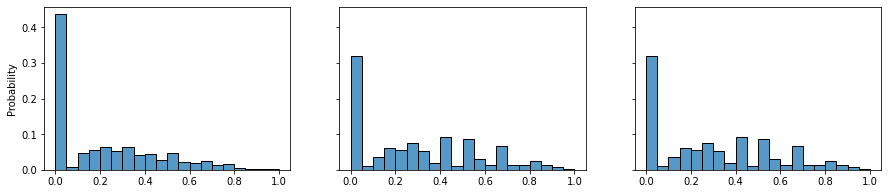

In [60]:
import seaborn as sns 
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 3))
sns.histplot(rouge_coco, bins=20, binrange=(0, 1), label="coco", ax=axes[0], stat="probability")
sns.histplot(rouge_hf, bins=20, binrange=(0, 1), label="hf-no-stem", ax=axes[1], stat="probability")
sns.histplot(rouge_hf_w_stemmer, bins=20, binrange=(0, 1), label="hf-stem", ax=axes[2], stat="probability")

In [7]:
rouge=load_metric("rouge", keep_in_memory=True) 

In [26]:
examples = data["drop"]
candidate = [[remove_punc(ex["candidate"])] for ex in examples.values()]
reference = [[remove_punc(ex["reference"])] for ex in examples.values()]

scores = rouge.compute(predictions=candidate, references=reference, use_stemmer=True, use_aggregator=False)
scores

{'rouge1': [Score(precision=0.42857142857142855, recall=1.0, fmeasure=0.6),
  Score(precision=0.0, recall=0.0, fmeasure=0.0),
  Score(precision=0.2857142857142857, recall=0.5, fmeasure=0.36363636363636365),
  Score(precision=0.3333333333333333, recall=0.3333333333333333, fmeasure=0.3333333333333333),
  Score(precision=0.0, recall=0.0, fmeasure=0.0),
  Score(precision=0.0, recall=0.0, fmeasure=0.0),
  Score(precision=1.0, recall=0.5, fmeasure=0.6666666666666666),
  Score(precision=0.0, recall=0.0, fmeasure=0.0),
  Score(precision=1.0, recall=0.375, fmeasure=0.5454545454545454),
  Score(precision=0.3333333333333333, recall=0.1111111111111111, fmeasure=0.16666666666666666),
  Score(precision=0.0, recall=0.0, fmeasure=0.0),
  Score(precision=0.0, recall=0.0, fmeasure=0.0),
  Score(precision=1.0, recall=1.0, fmeasure=1.0),
  Score(precision=0.6666666666666666, recall=0.6666666666666666, fmeasure=0.6666666666666666),
  Score(precision=0.0, recall=0.0, fmeasure=0.0),
  Score(precision=0.0, re